In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
np.mean([99.8, 99.0, 99.9, 93.6, 99.4, 99.6, 99.8]), np.std([99.8, 99.0, 99.9, 93.6, 99.4, 99.6, 99.8])

(98.72857142857143, 2.1130305154407214)

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
date = "20190816"
run_name = "08_16_2019_run_01"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import smith_waterman as s_w

In [10]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [11]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [12]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[10:19:49 - __main__] Getting molbit sequences.
[10:19:49 - __main__] Locating fastq files.
[10:19:49 - __main__] Running SW, one fastq at a time.
[10:19:49 - __main__] Starting fastq (0 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_0.fastq


[########################################] | 100% Completed | 58.5s


[10:20:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_0.tsv
[10:20:48 - __main__] Starting fastq (1 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_1.fastq


[########################################] | 100% Completed | 35.0s


[10:21:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_1.tsv
[10:21:24 - __main__] Starting fastq (2 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_2.fastq


[########################################] | 100% Completed | 28.5s


[10:21:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_2.tsv
[10:21:52 - __main__] Starting fastq (3 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_3.fastq


[########################################] | 100% Completed | 19.5s


[10:22:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_0_3.tsv
[10:22:12 - __main__] Starting fastq (4 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_0.fastq


[########################################] | 100% Completed | 16.9s


[10:22:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_0.tsv
[10:22:29 - __main__] Starting fastq (5 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_1.fastq


[########################################] | 100% Completed | 40.5s


[10:23:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_1.tsv
[10:23:10 - __main__] Starting fastq (6 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_2.fastq


[########################################] | 100% Completed | 52.6s


[10:24:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_2.tsv
[10:24:03 - __main__] Starting fastq (7 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_0.fastq


[########################################] | 100% Completed | 53.8s


[10:24:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_0.tsv
[10:24:57 - __main__] Starting fastq (8 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_3.fastq


[########################################] | 100% Completed | 29.8s


[10:25:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_1_3.tsv
[10:25:27 - __main__] Starting fastq (9 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_1.fastq


[########################################] | 100% Completed | 49.5s


[10:26:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_1.tsv
[10:26:17 - __main__] Starting fastq (10 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_2.fastq


[########################################] | 100% Completed | 23.1s


[10:26:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_2.tsv
[10:26:41 - __main__] Starting fastq (11 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_3.fastq


[########################################] | 100% Completed | 15.0s


[10:26:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_2_3.tsv
[10:26:56 - __main__] Starting fastq (12 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_0.fastq


[########################################] | 100% Completed |  1min  4.4s


[10:28:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_0.tsv
[10:28:01 - __main__] Starting fastq (13 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_1.fastq


[########################################] | 100% Completed | 41.4s


[10:28:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_1.tsv
[10:28:43 - __main__] Starting fastq (14 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_2.fastq


[########################################] | 100% Completed | 33.3s


[10:29:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_2.tsv
[10:29:16 - __main__] Starting fastq (15 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_0.fastq


[########################################] | 100% Completed | 41.9s


[10:29:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_0.tsv
[10:29:58 - __main__] Starting fastq (16 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_3.fastq


[########################################] | 100% Completed |  2.7s


[10:30:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_3_3.tsv
[10:30:01 - __main__] Starting fastq (17 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_1.fastq


[########################################] | 100% Completed | 40.6s


[10:30:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_1.tsv
[10:30:42 - __main__] Starting fastq (18 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_2.fastq


[########################################] | 100% Completed |  4.4s


[10:30:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_2.tsv
[10:30:47 - __main__] Starting fastq (19 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_0.fastq


[########################################] | 100% Completed | 39.8s


[10:31:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_0.tsv
[10:31:27 - __main__] Starting fastq (20 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_1.fastq


[########################################] | 100% Completed | 44.5s


[10:32:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_1.tsv
[10:32:12 - __main__] Starting fastq (21 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_2.fastq


[########################################] | 100% Completed | 52.3s


[10:33:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_2.tsv
[10:33:05 - __main__] Starting fastq (22 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_3.fastq


[########################################] | 100% Completed | 53.0s


[10:33:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_4_3.tsv
[10:33:58 - __main__] Starting fastq (23 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_0.fastq


[########################################] | 100% Completed | 41.5s


[10:34:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_0.tsv
[10:34:40 - __main__] Starting fastq (24 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_1.fastq


[########################################] | 100% Completed | 34.2s


[10:35:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_1.tsv
[10:35:15 - __main__] Starting fastq (25 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_3.fastq


[########################################] | 100% Completed |  1.7s


[10:35:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_5_3.tsv
[10:35:17 - __main__] Starting fastq (26 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_2.fastq


[########################################] | 100% Completed | 42.2s


[10:35:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_2.tsv
[10:35:59 - __main__] Starting fastq (27 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_0.fastq


[########################################] | 100% Completed | 44.8s


[10:36:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_0.tsv
[10:36:44 - __main__] Starting fastq (28 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_3.fastq


[########################################] | 100% Completed | 19.7s


[10:37:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_6_3.tsv
[10:37:04 - __main__] Starting fastq (29 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_1.fastq


[########################################] | 100% Completed | 30.2s


[10:37:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_1.tsv
[10:37:35 - __main__] Starting fastq (30 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_2.fastq


[########################################] | 100% Completed | 30.8s


[10:38:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_2.tsv
[10:38:06 - __main__] Starting fastq (31 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_3.fastq


[########################################] | 100% Completed | 32.5s


[10:38:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_7_3.tsv
[10:38:39 - __main__] Starting fastq (32 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_0.fastq


[########################################] | 100% Completed | 26.0s


[10:39:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_0.tsv
[10:39:05 - __main__] Starting fastq (33 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_1.fastq


[########################################] | 100% Completed | 38.3s


[10:39:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_1.tsv
[10:39:44 - __main__] Starting fastq (34 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_2.fastq


[########################################] | 100% Completed | 29.0s


[10:40:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_2.tsv
[10:40:13 - __main__] Starting fastq (35 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_0.fastq


[########################################] | 100% Completed | 34.9s


[10:40:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_0.tsv
[10:40:48 - __main__] Starting fastq (36 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_3.fastq


[########################################] | 100% Completed | 46.7s


[10:41:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_8_3.tsv
[10:41:35 - __main__] Starting fastq (37 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_1.fastq


[########################################] | 100% Completed |  1min 24.1s


[10:43:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_1.tsv
[10:43:00 - __main__] Starting fastq (38 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_2.fastq


[########################################] | 100% Completed | 15.2s


[10:43:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_2.tsv
[10:43:15 - __main__] Starting fastq (39 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_0.fastq


[########################################] | 100% Completed | 47.5s


[10:44:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_0.tsv
[10:44:03 - __main__] Starting fastq (40 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_1.fastq


[########################################] | 100% Completed | 39.7s


[10:44:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_1.tsv
[10:44:43 - __main__] Starting fastq (41 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_3.fastq


[########################################] | 100% Completed |  5.2s


[10:44:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_9_3.tsv
[10:44:49 - __main__] Starting fastq (42 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_11_0.fastq


[########################################] | 100% Completed | 53.7s


[10:45:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_11_0.tsv
[10:45:43 - __main__] Starting fastq (43 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_2.fastq


[########################################] | 100% Completed | 37.5s


[10:46:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_2.tsv
[10:46:21 - __main__] Starting fastq (44 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_11_1.fastq


[########################################] | 100% Completed | 54.6s


[10:47:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_11_1.tsv
[10:47:16 - __main__] Starting fastq (45 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_3.fastq


[########################################] | 100% Completed | 15.0s


[10:47:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_10_3.tsv
[10:47:31 - __main__] Starting fastq (46 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_11_2.fastq


[########################################] | 100% Completed |  1min 35.4s


[10:49:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_12_0.tsv
[10:49:39 - __main__] Starting fastq (49 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_12_1.fastq


[########################################] | 100% Completed |  4.3s


[10:49:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_12_1.tsv
[10:49:43 - __main__] Starting fastq (50 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_0.fastq


[########################################] | 100% Completed |  1min 28.8s


[10:51:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_0.tsv
[10:51:12 - __main__] Starting fastq (51 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_12_2.fastq


[########################################] | 100% Completed | 38.9s


[10:51:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_12_2.tsv
[10:51:52 - __main__] Starting fastq (52 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_1.fastq


[########################################] | 100% Completed | 30.9s


[10:52:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_1.tsv
[10:52:23 - __main__] Starting fastq (53 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_12_3.fastq


[########################################] | 100% Completed |  0.9s


[10:52:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_12_3.tsv
[10:52:24 - __main__] Starting fastq (54 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_2.fastq


[########################################] | 100% Completed |  3.4s


[10:52:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_2.tsv
[10:52:28 - __main__] Starting fastq (55 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_14_0.fastq


[########################################] | 100% Completed | 51.8s


[10:53:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_14_0.tsv
[10:53:20 - __main__] Starting fastq (56 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_3.fastq


[########################################] | 100% Completed | 17.2s


[10:53:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_13_3.tsv
[10:53:37 - __main__] Starting fastq (57 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_14_1.fastq


[########################                ] | 62% Completed | 44.8s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 25.7s


[11:02:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_17_3.tsv
[11:02:13 - __main__] Starting fastq (72 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_0.fastq


[########################################] | 100% Completed |  1min 25.1s


[11:03:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_0.tsv
[11:03:39 - __main__] Starting fastq (73 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_1.fastq


[########################################] | 100% Completed | 43.1s


[11:04:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_1.tsv
[11:04:22 - __main__] Starting fastq (74 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_2.fastq


[########################################] | 100% Completed | 13.2s


[11:04:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_2.tsv
[11:04:35 - __main__] Starting fastq (75 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_3.fastq


[########################################] | 100% Completed |  1.6s


[11:04:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_18_3.tsv
[11:04:37 - __main__] Starting fastq (76 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_19_0.fastq


[########################################] | 100% Completed | 40.1s


[11:05:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_19_0.tsv
[11:05:18 - __main__] Starting fastq (77 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_19_1.fastq


[########################################] | 100% Completed | 52.4s


[11:06:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_19_1.tsv
[11:06:11 - __main__] Starting fastq (78 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_19_2.fastq


[########################################] | 100% Completed | 48.4s


[11:06:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_19_2.tsv
[11:06:59 - __main__] Starting fastq (79 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_19_3.fastq


[                                        ] | 0% Completed |  0.6s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 59.3s


[11:13:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_22_1.tsv
[11:13:43 - __main__] Starting fastq (90 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_22_2.fastq


[########################################] | 100% Completed | 21.7s


[11:14:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_22_2.tsv
[11:14:05 - __main__] Starting fastq (91 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_22_3.fastq


[########################################] | 100% Completed |  3.2s


[11:14:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_22_3.tsv
[11:14:09 - __main__] Starting fastq (92 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_0.fastq


[########################################] | 100% Completed |  1min 10.0s


[11:15:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_0.tsv
[11:15:19 - __main__] Starting fastq (93 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_1.fastq


[########################################] | 100% Completed | 57.0s


[11:16:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_1.tsv
[11:16:17 - __main__] Starting fastq (94 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_2.fastq


[########################################] | 100% Completed | 14.1s


[11:16:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_2.tsv
[11:16:31 - __main__] Starting fastq (95 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_24_0.fastq


[########################################] | 100% Completed |  1min 20.6s


[11:17:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_24_0.tsv
[11:17:52 - __main__] Starting fastq (96 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_24_1.fastq


[########################################] | 100% Completed | 31.0s


[11:18:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_24_1.tsv
[11:18:23 - __main__] Starting fastq (97 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_3.fastq


[########################################] | 100% Completed |  2.6s


[11:18:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_23_3.tsv
[11:18:26 - __main__] Starting fastq (98 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_24_2.fastq


[###                                     ] | 7% Completed |  7.6s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 46.0s


[11:27:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_28_1.tsv
[11:27:51 - __main__] Starting fastq (114 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_28_2.fastq


[########################################] | 100% Completed | 29.5s


[11:28:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_28_2.tsv
[11:28:21 - __main__] Starting fastq (115 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_28_3.fastq


[########################################] | 100% Completed |  4.8s


[11:28:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_28_3.tsv
[11:28:26 - __main__] Starting fastq (116 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_0.fastq


[########################################] | 100% Completed | 53.8s


[11:29:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_0.tsv
[11:29:20 - __main__] Starting fastq (117 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_1.fastq


[########################################] | 100% Completed | 40.5s


[11:30:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_1.tsv
[11:30:01 - __main__] Starting fastq (118 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_2.fastq


[########################################] | 100% Completed | 35.6s


[11:30:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_2.tsv
[11:30:37 - __main__] Starting fastq (119 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_30_0.fastq


[########################################] | 100% Completed | 29.8s


[11:31:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_30_0.tsv
[11:31:07 - __main__] Starting fastq (120 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_30_1.fastq


[########################################] | 100% Completed |  1min 11.4s


[11:32:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_30_1.tsv
[11:32:19 - __main__] Starting fastq (121 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_3.fastq


[########################################] | 100% Completed | 11.5s


[11:32:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_29_3.tsv
[11:32:31 - __main__] Starting fastq (122 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_30_2.fastq


[########                                ] | 21% Completed |  8.6s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  1min  5.5s


[11:42:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_34_1.tsv
[11:42:38 - __main__] Starting fastq (138 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_34_2.fastq


[########################################] | 100% Completed |  7.4s


[11:42:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_34_2.tsv
[11:42:45 - __main__] Starting fastq (139 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_35_0.fastq


[########################################] | 100% Completed |  1min 12.6s


[11:43:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_35_0.tsv
[11:43:59 - __main__] Starting fastq (140 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_34_3.fastq


[########################################] | 100% Completed |  1.4s


[11:44:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_34_3.tsv
[11:44:00 - __main__] Starting fastq (141 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_35_1.fastq


[########################################] | 100% Completed | 28.8s


[11:44:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_35_1.tsv
[11:44:29 - __main__] Starting fastq (142 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_35_2.fastq


[########################################] | 100% Completed | 13.6s


[11:44:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_35_2.tsv
[11:44:43 - __main__] Starting fastq (143 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_36_0.fastq


[########################################] | 100% Completed | 53.1s


[11:45:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_36_0.tsv
[11:45:37 - __main__] Starting fastq (144 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_36_1.fastq


[###############################         ] | 77% Completed |  1min  9.1s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 30.8s


[11:56:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_40_1.tsv
[11:56:18 - __main__] Starting fastq (162 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_40_2.fastq


[########################################] | 100% Completed | 21.0s


[11:56:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_40_2.tsv
[11:56:39 - __main__] Starting fastq (163 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_0.fastq


[########################################] | 100% Completed |  1min 33.3s


[11:58:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_0.tsv
[11:58:13 - __main__] Starting fastq (164 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_40_3.fastq


[########################################] | 100% Completed | 20.3s


[11:58:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_40_3.tsv
[11:58:33 - __main__] Starting fastq (165 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_1.fastq


[########################################] | 100% Completed | 31.3s


[11:59:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_1.tsv
[11:59:05 - __main__] Starting fastq (166 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_2.fastq


[########################################] | 100% Completed | 13.4s


[11:59:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_2.tsv
[11:59:19 - __main__] Starting fastq (167 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_0.fastq


[########################################] | 100% Completed |  1min  0.8s


[12:00:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_0.tsv
[12:00:20 - __main__] Starting fastq (168 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_1.fastq


[########################################] | 100% Completed | 30.4s


[12:00:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_1.tsv
[12:00:51 - __main__] Starting fastq (169 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_3.fastq


[########################################] | 100% Completed |  1.0s


[12:00:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_41_3.tsv
[12:00:52 - __main__] Starting fastq (170 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_2.fastq


[########################################] | 100% Completed | 32.5s


[12:01:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_2.tsv
[12:01:25 - __main__] Starting fastq (171 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_0.fastq


[########################################] | 100% Completed | 24.9s


[12:01:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_0.tsv
[12:01:50 - __main__] Starting fastq (172 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_1.fastq


[########################################] | 100% Completed | 41.0s


[12:02:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_1.tsv
[12:02:31 - __main__] Starting fastq (173 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_3.fastq


[########################################] | 100% Completed | 16.6s


[12:02:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_42_3.tsv
[12:02:48 - __main__] Starting fastq (174 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_2.fastq


[########################################] | 100% Completed | 40.3s


[12:03:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_2.tsv
[12:03:29 - __main__] Starting fastq (175 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_3.fastq


[########################################] | 100% Completed | 34.5s


[12:04:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_43_3.tsv
[12:04:04 - __main__] Starting fastq (176 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_0.fastq


[########################################] | 100% Completed | 47.9s


[12:04:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_0.tsv
[12:04:52 - __main__] Starting fastq (177 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_1.fastq


[########################################] | 100% Completed | 33.6s


[12:05:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_1.tsv
[12:05:26 - __main__] Starting fastq (178 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_2.fastq


[########################################] | 100% Completed | 38.4s


[12:06:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_2.tsv
[12:06:05 - __main__] Starting fastq (179 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_3.fastq


[########################################] | 100% Completed | 20.1s


[12:06:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_44_3.tsv
[12:06:25 - __main__] Starting fastq (180 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_0.fastq


[########################################] | 100% Completed | 49.6s


[12:07:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_0.tsv
[12:07:15 - __main__] Starting fastq (181 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_1.fastq


[########################################] | 100% Completed | 33.1s


[12:07:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_1.tsv
[12:07:49 - __main__] Starting fastq (182 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_2.fastq


[########################################] | 100% Completed | 57.5s


[12:08:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_2.tsv
[12:08:47 - __main__] Starting fastq (183 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_3.fastq


[########################################] | 100% Completed |  1.7s


[12:08:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_45_3.tsv
[12:08:49 - __main__] Starting fastq (184 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_0.fastq


[########################################] | 100% Completed | 55.9s


[12:09:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_0.tsv
[12:09:45 - __main__] Starting fastq (185 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_1.fastq


[########################################] | 100% Completed |  1min 12.5s


[12:10:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_1.tsv
[12:10:58 - __main__] Starting fastq (186 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_2.fastq


[########################################] | 100% Completed |  8.5s


[12:11:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_2.tsv
[12:11:07 - __main__] Starting fastq (187 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_0.fastq


[########################################] | 100% Completed | 53.2s


[12:12:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_0.tsv
[12:12:00 - __main__] Starting fastq (188 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_3.fastq


[########################################] | 100% Completed |  3.4s


[12:12:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_46_3.tsv
[12:12:04 - __main__] Starting fastq (189 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_1.fastq


[########################################] | 100% Completed | 45.2s


[12:12:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_1.tsv
[12:12:49 - __main__] Starting fastq (190 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_2.fastq


[########################################] | 100% Completed |  5.2s


[12:12:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_2.tsv
[12:12:55 - __main__] Starting fastq (191 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_3.fastq


[########################################] | 100% Completed | 35.2s


[12:13:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_47_3.tsv
[12:13:30 - __main__] Starting fastq (192 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_0.fastq


[########################################] | 100% Completed |  1min  2.2s


[12:14:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_0.tsv
[12:14:33 - __main__] Starting fastq (193 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_1.fastq


[########################################] | 100% Completed | 36.9s


[12:15:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_1.tsv
[12:15:10 - __main__] Starting fastq (194 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_2.fastq


[########################################] | 100% Completed | 34.9s


[12:15:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_2.tsv
[12:15:46 - __main__] Starting fastq (195 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_0.fastq


[########################################] | 100% Completed | 45.0s


[12:16:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_0.tsv
[12:16:31 - __main__] Starting fastq (196 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_3.fastq


[########################################] | 100% Completed |  6.8s


[12:16:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_48_3.tsv
[12:16:38 - __main__] Starting fastq (197 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_1.fastq


[########################################] | 100% Completed | 40.8s


[12:17:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_1.tsv
[12:17:19 - __main__] Starting fastq (198 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_2.fastq


[########################################] | 100% Completed | 50.4s


[12:18:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_2.tsv
[12:18:10 - __main__] Starting fastq (199 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_3.fastq


[########################################] | 100% Completed |  2.7s


[12:18:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_49_3.tsv
[12:18:13 - __main__] Starting fastq (200 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_0.fastq


[########################################] | 100% Completed |  1min 29.9s


[12:19:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_0.tsv
[12:19:43 - __main__] Starting fastq (201 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_1.fastq


[########################################] | 100% Completed |  7.4s


[12:19:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_1.tsv
[12:19:51 - __main__] Starting fastq (202 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_0.fastq


[########################################] | 100% Completed |  1min 34.8s


[12:21:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_0.tsv
[12:21:26 - __main__] Starting fastq (203 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_2.fastq


[########################################] | 100% Completed |  9.4s


[12:21:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_2.tsv
[12:21:36 - __main__] Starting fastq (204 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_1.fastq


[########################################] | 100% Completed | 25.8s


[12:22:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_1.tsv
[12:22:02 - __main__] Starting fastq (205 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_3.fastq


[########################################] | 100% Completed | 33.9s


[12:22:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_50_3.tsv
[12:22:36 - __main__] Starting fastq (206 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_2.fastq


[########################################] | 100% Completed | 16.1s


[12:22:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_2.tsv
[12:22:53 - __main__] Starting fastq (207 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_0.fastq


[########################################] | 100% Completed |  1min 19.1s


[12:24:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_0.tsv
[12:24:12 - __main__] Starting fastq (208 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_1.fastq


[########################################] | 100% Completed | 21.9s


[12:24:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_1.tsv
[12:24:34 - __main__] Starting fastq (209 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_2.fastq


[########################################] | 100% Completed | 33.0s


[12:25:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_2.tsv
[12:25:08 - __main__] Starting fastq (210 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_3.fastq


[########################################] | 100% Completed |  1.2s


[12:25:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_51_3.tsv
[12:25:09 - __main__] Starting fastq (211 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_3.fastq


[########################################] | 100% Completed |  6.6s


[12:25:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_52_3.tsv
[12:25:16 - __main__] Starting fastq (212 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_0.fastq


[########################################] | 100% Completed | 25.7s


[12:25:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_0.tsv
[12:25:42 - __main__] Starting fastq (213 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_1.fastq


[########################################] | 100% Completed | 35.1s


[12:26:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_1.tsv
[12:26:17 - __main__] Starting fastq (214 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_2.fastq


[########################################] | 100% Completed | 45.1s


[12:27:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_2.tsv
[12:27:03 - __main__] Starting fastq (215 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_3.fastq


[########################################] | 100% Completed | 33.4s


[12:27:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_53_3.tsv
[12:27:37 - __main__] Starting fastq (216 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_0.fastq


[########################################] | 100% Completed | 40.8s


[12:28:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_0.tsv
[12:28:18 - __main__] Starting fastq (217 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_1.fastq


[########################################] | 100% Completed | 57.7s


[12:29:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_1.tsv
[12:29:16 - __main__] Starting fastq (218 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_2.fastq


[########################################] | 100% Completed | 29.0s


[12:29:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_2.tsv
[12:29:45 - __main__] Starting fastq (219 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_3.fastq


[########################################] | 100% Completed | 10.4s


[12:29:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_54_3.tsv
[12:29:56 - __main__] Starting fastq (220 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_0.fastq


[########################################] | 100% Completed | 56.7s


[12:30:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_0.tsv
[12:30:53 - __main__] Starting fastq (221 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_1.fastq


[########################################] | 100% Completed | 47.0s


[12:31:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_1.tsv
[12:31:40 - __main__] Starting fastq (222 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_2.fastq


[########################################] | 100% Completed | 33.5s


[12:32:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_2.tsv
[12:32:14 - __main__] Starting fastq (223 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_0.fastq


[########################################] | 100% Completed | 34.1s


[12:32:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_0.tsv
[12:32:49 - __main__] Starting fastq (224 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_1.fastq


[########################################] | 100% Completed | 42.4s


[12:33:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_1.tsv
[12:33:32 - __main__] Starting fastq (225 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_3.fastq


[########################################] | 100% Completed |  3.6s


[12:33:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_55_3.tsv
[12:33:35 - __main__] Starting fastq (226 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_2.fastq


[########################################] | 100% Completed |  1min  5.2s


[12:34:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_2.tsv
[12:34:41 - __main__] Starting fastq (227 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_0.fastq


[########################################] | 100% Completed |  1min  1.1s


[12:35:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_0.tsv
[12:35:43 - __main__] Starting fastq (228 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_1.fastq


[########################################] | 100% Completed | 44.4s


[12:36:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_1.tsv
[12:36:27 - __main__] Starting fastq (229 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_3.fastq


[########################################] | 100% Completed |  0.9s


[12:36:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_56_3.tsv
[12:36:29 - __main__] Starting fastq (230 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_2.fastq


[########################################] | 100% Completed | 11.1s


[12:36:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_2.tsv
[12:36:40 - __main__] Starting fastq (231 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_0.fastq


[########################################] | 100% Completed |  1min 18.4s


[12:37:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_0.tsv
[12:37:59 - __main__] Starting fastq (232 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_3.fastq


[########################################] | 100% Completed | 26.2s


[12:38:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_57_3.tsv
[12:38:25 - __main__] Starting fastq (233 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_1.fastq


[########################################] | 100% Completed | 22.0s


[12:38:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_1.tsv
[12:38:48 - __main__] Starting fastq (234 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_2.fastq


[########################################] | 100% Completed | 40.4s


[12:39:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_2.tsv
[12:39:28 - __main__] Starting fastq (235 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_3.fastq


[########################################] | 100% Completed |  0.9s


[12:39:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_58_3.tsv
[12:39:29 - __main__] Starting fastq (236 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_0.fastq


[########################################] | 100% Completed | 29.1s


[12:39:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_0.tsv
[12:39:59 - __main__] Starting fastq (237 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_1.fastq


[########################################] | 100% Completed | 47.2s


[12:40:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_1.tsv
[12:40:47 - __main__] Starting fastq (238 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_2.fastq


[########################################] | 100% Completed | 28.4s


[12:41:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_2.tsv
[12:41:15 - __main__] Starting fastq (239 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_3.fastq


[########################################] | 100% Completed | 34.7s


[12:41:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_59_3.tsv
[12:41:50 - __main__] Starting fastq (240 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_0.fastq


[########################################] | 100% Completed | 52.5s


[12:42:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_0.tsv
[12:42:43 - __main__] Starting fastq (241 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_1.fastq


[########################################] | 100% Completed | 37.8s


[12:43:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_1.tsv
[12:43:21 - __main__] Starting fastq (242 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_2.fastq


[########################################] | 100% Completed | 25.4s


[12:43:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_2.tsv
[12:43:47 - __main__] Starting fastq (243 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_3.fastq


[########################################] | 100% Completed | 26.4s


[12:44:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_60_3.tsv
[12:44:14 - __main__] Starting fastq (244 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_0.fastq


[########################################] | 100% Completed |  1min  8.4s


[12:45:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_0.tsv
[12:45:22 - __main__] Starting fastq (245 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_1.fastq


[########################################] | 100% Completed | 32.2s


[12:45:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_1.tsv
[12:45:55 - __main__] Starting fastq (246 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_2.fastq


[########################################] | 100% Completed | 28.1s


[12:46:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_2.tsv
[12:46:23 - __main__] Starting fastq (247 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_3.fastq


[########################################] | 100% Completed | 10.7s


[12:46:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_61_3.tsv
[12:46:34 - __main__] Starting fastq (248 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_0.fastq


[########################################] | 100% Completed |  1min 14.7s


[12:47:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_0.tsv
[12:47:50 - __main__] Starting fastq (249 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_1.fastq


[########################################] | 100% Completed | 27.1s


[12:48:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_1.tsv
[12:48:17 - __main__] Starting fastq (250 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_2.fastq


[########################################] | 100% Completed | 35.6s


[12:48:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_2.tsv
[12:48:53 - __main__] Starting fastq (251 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_3.fastq


[########################################] | 100% Completed |  2.5s


[12:48:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_62_3.tsv
[12:48:56 - __main__] Starting fastq (252 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_0.fastq


[########################################] | 100% Completed |  1min 16.8s


[12:50:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_0.tsv
[12:50:13 - __main__] Starting fastq (253 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_1.fastq


[########################################] | 100% Completed | 11.5s


[12:50:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_1.tsv
[12:50:25 - __main__] Starting fastq (254 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_2.fastq


[########################################] | 100% Completed | 48.5s


[12:51:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_2.tsv
[12:51:14 - __main__] Starting fastq (255 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_3.fastq


[########################################] | 100% Completed |  3.6s


[12:51:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_63_3.tsv
[12:51:17 - __main__] Starting fastq (256 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_0.fastq


[########################################] | 100% Completed | 50.6s


[12:52:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_0.tsv
[12:52:08 - __main__] Starting fastq (257 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_1.fastq


[########################################] | 100% Completed | 41.2s


[12:52:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_1.tsv
[12:52:50 - __main__] Starting fastq (258 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_2.fastq


[########################################] | 100% Completed | 48.4s


[12:53:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_2.tsv
[12:53:39 - __main__] Starting fastq (259 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_0.fastq


[########################################] | 100% Completed |  1min  4.4s


[12:54:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_0.tsv
[12:54:44 - __main__] Starting fastq (260 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_1.fastq


[########################################] | 100% Completed | 38.0s


[12:55:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_1.tsv
[12:55:22 - __main__] Starting fastq (261 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_3.fastq


[########################################] | 100% Completed |  1.0s


[12:55:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_64_3.tsv
[12:55:23 - __main__] Starting fastq (262 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_2.fastq


[########################################] | 100% Completed | 32.7s


[12:55:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_2.tsv
[12:55:56 - __main__] Starting fastq (263 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_3.fastq


[########################################] | 100% Completed |  4.6s


[12:56:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_65_3.tsv
[12:56:01 - __main__] Starting fastq (264 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_0.fastq


[########################################] | 100% Completed |  1min  1.3s


[12:57:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_0.tsv
[12:57:03 - __main__] Starting fastq (265 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_1.fastq


[########################################] | 100% Completed | 58.9s


[12:58:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_1.tsv
[12:58:02 - __main__] Starting fastq (266 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_2.fastq


[########################################] | 100% Completed | 15.6s


[12:58:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_2.tsv
[12:58:18 - __main__] Starting fastq (267 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_3.fastq


[########################################] | 100% Completed |  3.6s


[12:58:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_66_3.tsv
[12:58:22 - __main__] Starting fastq (268 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_0.fastq


[########################################] | 100% Completed |  1min 15.5s


[12:59:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_0.tsv
[12:59:38 - __main__] Starting fastq (269 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_1.fastq


[########################################] | 100% Completed | 33.4s


[13:00:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_1.tsv
[13:00:12 - __main__] Starting fastq (270 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_2.fastq


[########################################] | 100% Completed | 18.8s


[13:00:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_2.tsv
[13:00:31 - __main__] Starting fastq (271 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_3.fastq


[########################################] | 100% Completed | 13.5s


[13:00:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_67_3.tsv
[13:00:45 - __main__] Starting fastq (272 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_0.fastq


[########################################] | 100% Completed | 53.0s


[13:01:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_0.tsv
[13:01:38 - __main__] Starting fastq (273 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_1.fastq


[########################################] | 100% Completed | 37.9s


[13:02:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_1.tsv
[13:02:16 - __main__] Starting fastq (274 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_2.fastq


[########################################] | 100% Completed | 20.8s


[13:02:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_2.tsv
[13:02:37 - __main__] Starting fastq (275 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_3.fastq


[########################################] | 100% Completed | 29.4s


[13:03:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_68_3.tsv
[13:03:07 - __main__] Starting fastq (276 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_0.fastq


[########################################] | 100% Completed |  1min 14.3s


[13:04:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_0.tsv
[13:04:22 - __main__] Starting fastq (277 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_1.fastq


[########################################] | 100% Completed | 39.5s


[13:05:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_1.tsv
[13:05:02 - __main__] Starting fastq (278 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_2.fastq


[########################################] | 100% Completed | 14.7s


[13:05:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_2.tsv
[13:05:17 - __main__] Starting fastq (279 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_3.fastq


[########################################] | 100% Completed | 12.3s


[13:05:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_69_3.tsv
[13:05:29 - __main__] Starting fastq (280 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_0.fastq


[########################################] | 100% Completed |  1min  2.0s


[13:06:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_0.tsv
[13:06:32 - __main__] Starting fastq (281 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_1.fastq


[########################################] | 100% Completed | 49.0s


[13:07:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_1.tsv
[13:07:21 - __main__] Starting fastq (282 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_2.fastq


[########################################] | 100% Completed | 26.0s


[13:07:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_2.tsv
[13:07:47 - __main__] Starting fastq (283 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_3.fastq


[########################################] | 100% Completed |  1.8s


[13:07:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_70_3.tsv
[13:07:49 - __main__] Starting fastq (284 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_0.fastq


[########################################] | 100% Completed | 45.6s


[13:08:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_0.tsv
[13:08:35 - __main__] Starting fastq (285 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_1.fastq


[########################################] | 100% Completed | 30.4s


[13:09:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_1.tsv
[13:09:06 - __main__] Starting fastq (286 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_2.fastq


[########################################] | 100% Completed | 56.5s


[13:10:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_2.tsv
[13:10:03 - __main__] Starting fastq (287 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_3.fastq


[########################################] | 100% Completed |  4.8s


[13:10:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_71_3.tsv
[13:10:08 - __main__] Starting fastq (288 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_0.fastq


[########################################] | 100% Completed |  1min  4.5s


[13:11:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_0.tsv
[13:11:13 - __main__] Starting fastq (289 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_1.fastq


[########################################] | 100% Completed | 29.5s


[13:11:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_1.tsv
[13:11:43 - __main__] Starting fastq (290 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_2.fastq


[########################################] | 100% Completed | 44.2s


[13:12:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_2.tsv
[13:12:27 - __main__] Starting fastq (291 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_0.fastq


[########################################] | 100% Completed |  1min  1.4s


[13:13:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_0.tsv
[13:13:29 - __main__] Starting fastq (292 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_3.fastq


[########################################] | 100% Completed |  1.7s


[13:13:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_72_3.tsv
[13:13:31 - __main__] Starting fastq (293 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_1.fastq


[########################################] | 100% Completed | 52.2s


[13:14:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_1.tsv
[13:14:24 - __main__] Starting fastq (294 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_2.fastq


[########################################] | 100% Completed |  6.5s


[13:14:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_2.tsv
[13:14:31 - __main__] Starting fastq (295 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_3.fastq


[########################################] | 100% Completed | 19.0s


[13:14:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_73_3.tsv
[13:14:50 - __main__] Starting fastq (296 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_0.fastq


[########################################] | 100% Completed | 17.0s


[13:15:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_0.tsv
[13:15:07 - __main__] Starting fastq (297 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_1.fastq


[########################################] | 100% Completed | 50.4s


[13:15:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_1.tsv
[13:15:58 - __main__] Starting fastq (298 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_2.fastq


[########################################] | 100% Completed | 10.1s


[13:16:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_2.tsv
[13:16:08 - __main__] Starting fastq (299 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_0.fastq


[########################################] | 100% Completed | 40.5s


[13:16:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_0.tsv
[13:16:49 - __main__] Starting fastq (300 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_1.fastq


[########################################] | 100% Completed |  1min  4.0s


[13:17:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_1.tsv
[13:17:54 - __main__] Starting fastq (301 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_3.fastq


[########################################] | 100% Completed |  1min  1.1s


[13:18:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_74_3.tsv
[13:18:55 - __main__] Starting fastq (302 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_2.fastq


[########################################] | 100% Completed | 31.2s


[13:19:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_2.tsv
[13:19:27 - __main__] Starting fastq (303 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_0.fastq


[########################################] | 100% Completed |  1min  4.9s


[13:20:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_0.tsv
[13:20:32 - __main__] Starting fastq (304 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_3.fastq


[########################################] | 100% Completed |  2.5s


[13:20:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_75_3.tsv
[13:20:35 - __main__] Starting fastq (305 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_1.fastq


[########################################] | 100% Completed | 32.2s


[13:21:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_1.tsv
[13:21:08 - __main__] Starting fastq (306 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_2.fastq


[########################################] | 100% Completed | 43.2s


[13:21:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_2.tsv
[13:21:51 - __main__] Starting fastq (307 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_0.fastq


[########################################] | 100% Completed | 59.8s


[13:22:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_0.tsv
[13:22:51 - __main__] Starting fastq (308 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_1.fastq


[########################################] | 100% Completed | 25.3s


[13:23:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_1.tsv
[13:23:17 - __main__] Starting fastq (309 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_3.fastq


[########################################] | 100% Completed |  1.4s


[13:23:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_76_3.tsv
[13:23:18 - __main__] Starting fastq (310 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_2.fastq


[########################################] | 100% Completed | 37.3s


[13:23:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_2.tsv
[13:23:56 - __main__] Starting fastq (311 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_0.fastq


[########################################] | 100% Completed |  1min 12.9s


[13:25:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_0.tsv
[13:25:09 - __main__] Starting fastq (312 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_3.fastq


[########################################] | 100% Completed | 15.3s


[13:25:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_77_3.tsv
[13:25:25 - __main__] Starting fastq (313 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_1.fastq


[########################################] | 100% Completed | 34.4s


[13:26:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_1.tsv
[13:26:00 - __main__] Starting fastq (314 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_2.fastq


[########################################] | 100% Completed |  1.0s


[13:26:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_2.tsv
[13:26:01 - __main__] Starting fastq (315 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_0.fastq


[########################################] | 100% Completed |  1min 48.4s


[13:27:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_0.tsv
[13:27:50 - __main__] Starting fastq (316 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_3.fastq


[########################################] | 100% Completed | 32.8s


[13:28:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_78_3.tsv
[13:28:23 - __main__] Starting fastq (317 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_1.fastq


[########################################] | 100% Completed | 14.6s


[13:28:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_1.tsv
[13:28:38 - __main__] Starting fastq (318 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_0.fastq


[########################################] | 100% Completed | 32.4s


[13:29:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_0.tsv
[13:29:11 - __main__] Starting fastq (319 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_2.fastq


[########################################] | 100% Completed |  1.0s


[13:29:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_2.tsv
[13:29:12 - __main__] Starting fastq (320 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_1.fastq


[########################################] | 100% Completed | 53.8s


[13:30:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_1.tsv
[13:30:06 - __main__] Starting fastq (321 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_3.fastq


[########################################] | 100% Completed | 16.5s


[13:30:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_79_3.tsv
[13:30:23 - __main__] Starting fastq (322 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_2.fastq


[########################################] | 100% Completed | 45.1s


[13:31:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_2.tsv
[13:31:09 - __main__] Starting fastq (323 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_3.fastq


[########################################] | 100% Completed |  9.0s


[13:31:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_80_3.tsv
[13:31:18 - __main__] Starting fastq (324 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_0.fastq


[########################################] | 100% Completed | 57.7s


[13:32:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_0.tsv
[13:32:16 - __main__] Starting fastq (325 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_1.fastq


[########################################] | 100% Completed | 33.4s


[13:32:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_1.tsv
[13:32:50 - __main__] Starting fastq (326 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_2.fastq


[########################################] | 100% Completed |  6.1s


[13:32:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_2.tsv
[13:32:56 - __main__] Starting fastq (327 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_81_0.fastq


[########################################] | 100% Completed |  5.0s


[13:33:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_81_0.tsv
[13:33:02 - __main__] Starting fastq (328 of 329)
	/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/pass/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_3.fastq


[########################################] | 100% Completed | 44.8s


[13:33:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/fastq_runid_c00d4d8a06893e7015df48ef09339662a1747216_82_3.tsv


In [13]:
sw_list = []
for fname in os.listdir(sw_dir):
    if "all" in fname:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [14]:
sw_arr = np.array(sw)

In [15]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

[13:33:52 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[13:33:52 - matplotlib.fo

[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[13:33:52 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[13:33:52 - matplotlib.font_manager] 

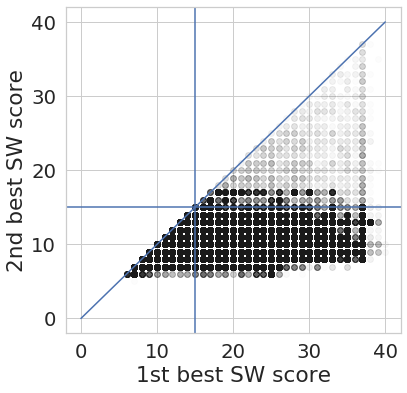

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

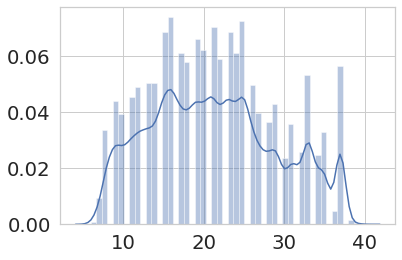

In [17]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [18]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [19]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [20]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [21]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190816/guppy_3.2.2_08_16_2019_run_01_exec_20190819/sw/all_c00d4d8a06893e7015df48ef09339662a1747216.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [22]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [23]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

4
['64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79']
5
['80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95']
['48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95']


## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [24]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [25]:
len(accept_molbit)

291232

In [26]:
sum(accept_molbit)

227466

In [27]:
sum(accept_molbit) / len(accept_molbit)

0.7810474123722668

## Extract the best-aligned molbit, across ONLY the extant molbits

In [44]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [45]:
extant_sw = sw.loc[:, extant_sw_cols]

In [46]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [47]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [48]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [49]:
n_extant_is_best

227204

Percentage of well-aligned reads that belong to the true set

In [50]:
n_extant_is_best/len(sw_accepted)

0.9988481795081463

Read counts for each molbit

In [51]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('48', 10428),
 ('49', 3946),
 ('50', 20888),
 ('51', 18657),
 ('52', 12227),
 ('53', 8244),
 ('54', 11752),
 ('55', 9923),
 ('56', 6404),
 ('57', 11443),
 ('58', 20366),
 ('59', 5823),
 ('60', 30533),
 ('61', 16292),
 ('62', 17285),
 ('63', 21854),
 ('65', 2),
 ('66', 1),
 ('67', 40),
 ('68', 2),
 ('69', 3),
 ('70', 3),
 ('71', 3),
 ('72', 3),
 ('73', 2),
 ('74', 5),
 ('75', 7),
 ('76', 17),
 ('77', 7),
 ('78', 2),
 ('79', 5),
 ('80', 8),
 ('81', 16),
 ('82', 5),
 ('83', 2),
 ('84', 1),
 ('85', 99),
 ('86', 9),
 ('87', 10),
 ('88', 7),
 ('89', 28),
 ('90', 11),
 ('91', 5),
 ('92', 60),
 ('93', 4),
 ('94', 1026),
 ('95', 8)]

In [52]:
print("\n".join([str(x) for x in c]))

10428
3946
20888
18657
12227
8244
11752
9923
6404
11443
20366
5823
30533
16292
17285
21854
2
1
40
2
3
3
3
3
2
5
7
17
7
2
5
8
16
5
2
1
99
9
10
7
28
11
5
60
4
1026
8


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [36]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [37]:
extant_sw = sw.loc[:, extant_sw_cols]

In [38]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [39]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [40]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [41]:
n_extant_is_best

225848

Percentage of well-aligned reads that belong to the true set

In [42]:
n_extant_is_best/len(sw_accepted)

0.9928868490235904

Read counts for each molbit

In [43]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('48', 10503),
 ('49', 3965),
 ('50', 20940),
 ('51', 18662),
 ('52', 12271),
 ('53', 8252),
 ('54', 11768),
 ('55', 9928),
 ('56', 6414),
 ('57', 11453),
 ('58', 21455),
 ('59', 5872),
 ('60', 30536),
 ('61', 16295),
 ('62', 17296),
 ('63', 21856)]

## Get counts for all molbits

In [82]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

2
0
5
0
0
1
0
49
9
1
0
0
1
21
0
9
4
13
0
1
0
0
0
0
13
2
0
1
0
0
3
1
0
1
0
24
61
4
0
1
1
1
15
2
2
0
11
3
10421
3913
20859
18652
12227
8244
11742
9911
6404
11441
20337
5808
30519
16270
17247
21853
0
1
1
39
2
3
2
2
3
1
5
6
15
2
0
5
8
16
5
2
1
81
9
10
7
28
11
3
54
4
1022
8
